#### Initial setup steps

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
# tf.keras.backend.clear_session()  # For easy reset of notebook state.
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
# import statements
import time
import numpy as np
import matplotlib.pyplot as plt

#### Loading the data and visualising the sample data

In [3]:
# loading the cifar dataset
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

print("total number of train examples {}".format(num_train))
print("total number of test examples {}".format(num_test))
print("total number of unique classes {}".format(num_classes))
print("the shape of each of the examples rows:{}, columns:{}, number of channels:{}".format(img_rows, img_cols, img_channels))

170500096/170498071 [==============================] - 7s 0us/step
total number of train examples 50000
total number of test examples 10000
total number of unique classes 10
the shape of each of the examples rows:32, columns:32, number of channels:3


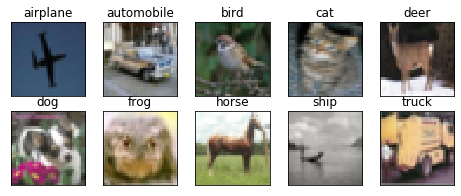

In [4]:
# visualizing one image from each of the classes
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# preprocessing steps
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

#### Utility functions to visualize the training progress

In [0]:
# function to plot the progress of loss and accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# function to calculate accuracy of prediction
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

#### Defining the resnet18 architecture

In [0]:
def convolution_block(x, filters, stage, block, stride=2):
  # defining the base name for all the layers in the block
  conv_name_base = "res" + str(stage) + block + "_branch"
  bn_name_base = "bn" + str(stage) + block + "_branch"

  # save the input value
  x_shortcut = x

  #### RESIDUAL PATH ####
  # first component of residual path with strided convolution
  x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=(3, 3), strides=(stride, stride), padding="same", name=conv_name_base + "2a")(x)
  x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + "2a")(x)
  x = tf.keras.layers.Activation("relu")(x)

  # second component of residual path
  x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=(3, 3), strides=(1, 1), padding="same", name=conv_name_base + "2b")(x)
  x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + "2b")(x)
  x = tf.keras.layers.Activation("relu")(x)

  #### SHORTCUT PATH ####
  x_shortcut = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=(1, 1), strides=(stride, stride), padding="same", name=conv_name_base + "1")(x_shortcut)
  x_shortcut = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + "1")(x_shortcut)

  # final step to add the output from residual and shortcut path and pass it through RELU activation
  x = tf.keras.layers.Add()([x, x_shortcut])
  x = tf.keras.layers.Activation("relu")(x)

  return x

In [0]:
def identity_block(x, filters, stage, block):
  # defining the base name for all the layers in the block
  conv_name_base = "res" + str(stage) + block + "_branch"
  bn_name_base = "bn" + str(stage) + block + "_branch"

  # save the input value
  x_shortcut = x

  #### RESIDUAL PATH ####
  # first component of residual path with strided convolution
  x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=(3, 3), strides=(1, 1), padding="same", name=conv_name_base + "2a")(x)
  x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + "2a")(x)
  x = tf.keras.layers.Activation("relu")(x)

  # second component of residual path
  x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=(3, 3), strides=(1, 1), padding="same", name=conv_name_base + "2b")(x)
  x = tf.keras.layers.BatchNormalization(axis=3, name=bn_name_base + "2b")(x)
  x = tf.keras.layers.Activation("relu")(x)

  # final step to add the output from residual and shortcut path and pass it through RELU activation
  x = tf.keras.layers.Add()([x, x_shortcut])
  x = tf.keras.layers.Activation("relu")(x)

  return x

In [0]:
def ResNet18(input_shape=(32, 32, 3), classes=10):
  # Define the input
  x_input = tf.keras.Input(input_shape)

  # zero-padding the input with 3 pixel, the step required for resnet
  x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

  # stage 1
  x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), name="conv1")(x)
  x = tf.keras.layers.BatchNormalization(axis=3, name="bn_conv1")(x)
  x = tf.keras.layers.Activation("relu")(x)
  x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

  # stage 2
  x = convolution_block(x, filters=[64, 64], stage=2, block="a", stride=1)
  x = identity_block(x, filters=[64, 64], stage=2, block="b")

  # stage 3
  x = convolution_block(x, filters=[128, 128], stage=3, block="a")
  x = identity_block(x, filters=[128, 128], stage=3, block="b")

  # stage 4
  x = convolution_block(x, filters=[256, 256], stage=4, block="a")
  x = identity_block(x, filters=[256, 256], stage=4, block="b")

  # stage 5
  x = convolution_block(x, filters=[512, 512], stage=5, block="a")
  x = identity_block(x, filters=[512, 512], stage=5, block="b")

  # Average pooling
  x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(x)

  # output layer
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(classes, activation="softmax", name="fc" + str(classes))(x)

  # create model
  model = tf.keras.Model(inputs = x_input, outputs=x, name="resnet18")
  
  return model

In [11]:
model = ResNet18(input_shape=(32, 32, 3), classes=10)
model.summary()

Model: "resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
# compiling the model
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

#### defining the preprocessing functions

In [0]:
# initializing the mean and standard deviation vector for image normalization
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

In [0]:
def image_normalization(input_img):
  input_img = input_img - mean
  input_img = input_img/std
  return input_img

def pad_image(input_img, padding_size):
  # function to pad the image with given padding size
  input_img_r = input_img[:, :, 0]
  input_img_g = input_img[:, :, 1]
  input_img_b = input_img[:, :, 2]
  input_img_r = np.pad(input_img_r, (padding_size, padding_size), 'reflect')
  input_img_g = np.pad(input_img_g, (padding_size, padding_size), 'reflect')
  input_img_b = np.pad(input_img_b, (padding_size, padding_size), 'reflect')
  input_img = np.dstack((input_img_r, input_img_g, input_img_b))
  return input_img

def random_crop(input_img, random_crop_size):
  # function to randomly crop the image with selected size
  height, width = input_img.shape[0], input_img.shape[1]
  dy, dx = random_crop_size
  x = np.random.randint(0, width - dx + 1)
  y = np.random.randint(0, height - dy + 1)
  return input_img[y:(y+dy), x:(x+dx), :]



def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
  """
  Args:
    p: the probability that random earsing is performed
    s_l, s_h: minimum/maximum proportion of erased area against input image
    r_1, r_2: minimum/maximum aspect ratio of erased area
    v_l, v_h: minimum/maximum value for erased area
    pixel_level: pixel-level randomization for earased area
  Returns:
    the eraser function for erasing a portion of the image
  """
  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
      return input_img

    while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)

      if left + w <= img_w and top + h <= img_h:
        break

    if pixel_level:
      c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
      c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

  return eraser

In [0]:
def train_preprocessing(input_img):
  normalized_img = image_normalization(input_img)
  padded_img = pad_image(normalized_img, 4)
  random_cropped_img = random_crop(padded_img, (32, 32))
  eraser_function = get_random_eraser()
  erased_img = eraser_function(random_cropped_img)
  return erased_img

In [0]:
def test_preprocessing(input_img):
  normalized_img = image_normalization(input_img)
  return normalized_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


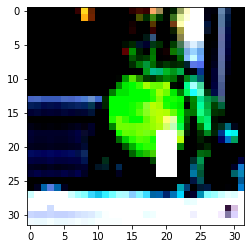

In [0]:
# visualizing an example image after training preprocessing steps
img = train_preprocessing(train_features[19])
plt.imshow(img)

#### Learning rate finder strategy

In [0]:
# code for finding the best learning rate, which will be used as a call back in model.fit function
# [lr finder](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)
# use the article in the link above to understand how the lr finder works 
class LR_Finder(tf.keras.callbacks.Callback):
  """
  class to find the best learning rate for training
  Args:
    start_lr: the initial learning rate which will be used for training
    end_lr: the final learning rate till the point the learning rate will be increased
    step_size: the step size which will be used to increase the learning rate
    beta: the beta value ranged between 0 to 1, which will be used to calculate the average loss
    lr_mult 
  """
  def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
    super().__init__()

    self.start_lr = start_lr
    self.end_lr = end_lr
    self.step_size = step_size
    self.beta = beta
    self.lr_mult = (end_lr/start_lr) ** (1/step_size)

  def on_train_begin(self, logs=None):
    self.best_loss = 1e9
    self.avg_loss = 0
    self.losses, self,smoothed_losses, self.lrs, self.iterations = [], [], [], []
    self.iteration = 0
    logs = logs or {}
    K.set_values(self.model.optimizer.lr, self.start_lr)

  def on_batch_end(self, epoch, logs=None):
    logs = logs or {}
    loss = logs.get('loss')
    self.iteration += 1

    self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
    smoothed_loss = self.avg_loss / (1 - self.beta ** self.iteration)

    # check if the loss is not exploding
    if self.iteration > 1 and smoothed_loss > self.best_loss * 4:
      self.model.stop_training = True
      return
    if smoothed_loss < self.best_loss or self.iteration == 1:
      self.best_loss = smoothed_loss

    lr = self.start_lr * (self.lr_mult ** self.iteration)

    self.losses.append(loss)
    self.smoothed_losses.append(smoothed_loss)
    self.lrs.append(lr)
    self.iterations.append(self.iteration)

    tf.keras.backend.set_value(self.model.optimizer.lr, lr)

  def plot_lr(self):
    plt.xlabel("Iterations")
    plt.ylabel("Learning rate")
    plt.plot(self.iterations, self.lrs)

  def plot(self, n_skip=10):
    plt.ylabel("Loss")
    plt.xlabel("Learning rate (log scale)")
    plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])

  def plot_smoothed_loss(self, n_skip=10):
    plt.ylabel("Smoothed Losses")
    plt.xlabel("Learning rate (log scale)")
    plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
    plt.xscale("log")

  def plot_loss(self):
    plt.ylabel("Losses")
    plt.xlabel("Iterations")
    plt.plot(self.iterations[10:], self.losses[10:])

#### training procedure


In [0]:
# train and test datagenerators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.0, 
    horizontal_flip=0.5,
    preprocessing_function=train_preprocessing)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=False,
    preprocessing_function=test_preprocessing)

In [0]:
# compiling the model and training
model.compile(optimizer = 'SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# train the model
start = time.time()
model_info = model.fit_generator(
    train_datagen.flow(
        train_features,
        train_labels,
        batch_size = 128),
    steps_per_epoch = train_features.shape[0]/128,
    epochs = 300,
    validation_data = test_datagen.flow(
        test_features,
        test_labels,
        batch_size=512),
    verbose=1)
    # callbacks=[one_cycle_lr, checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/300
116/390 [=======>......................] - ETA: 56s - loss: 2.5633 - accuracy: 0.1378

KeyboardInterrupt: ignored